In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [0]:
data = pd.read_excel('DATASET.xlsx')

In [3]:
data.shape

(88853, 16)

In [0]:
data['AD_WEEK_ENDING_DATE'] = pd.to_datetime(data['AD_WEEK_ENDING_DATE'])

# Checking null values

In [5]:
# checking the percentage of missing values in each variable
data.isnull().sum()/len(data)*100

Group Id                      0.000000
AD_WEEK_ENDING_DATE           0.000000
Category                      0.000000
Number of stores              0.000000
markdown                      0.000000
scan_cost                     0.000000
promos                        0.000000
print_ad                      0.000000
digital_ad                    0.000000
instore_ad                    0.000000
mechanism of promotion        0.000000
national_brand                0.000000
total_tonnage                 0.000000
total_sales                   0.000000
price                         0.847467
num_of_stores_on_promotion    0.000000
dtype: float64

In [6]:
data['price'].isnull().sum()

753

In [0]:
# price column includes missing values...so droping those rows
data = data.dropna(subset = ['price'], axis=0)

In [8]:
data.head()

,Group Id,AD_WEEK_ENDING_DATE,Category,Number of stores,markdown,scan_cost,promos,print_ad,digital_ad,instore_ad,mechanism of promotion,national_brand,total_tonnage,total_sales,price,num_of_stores_on_promotion
0,85392300293,2017-01-17,790,73,84.16,785.700,1,1,0,1,5,1,582.0,1155.00,1.984536,84
1,35087,2019-09-24,790,39,59.68,473.850,1,0,0,1,3,1,486.0,810.14,1.666955,36
2,81829001026,2017-03-01,790,70,40.32,293.000,1,0,0,1,3,1,293.0,352.75,1.203925,55
3,81590902027,2018-02-13,790,34,47.43,347.170,1,0,0,1,5,1,233.0,459.00,1.969957,72
4,30601,2017-10-01,575,100,878.54,7290.068,1,1,0,1,4,1,6658.0,9935.30,1.492235,71


### removing rows where total_sales, total_tonnage, price, scan_cost <= 0

In [0]:
for col in ['scan_cost','total_tonnage', 'total_sales', 'price']:
  data = data.loc[data[col] > 0]

In [10]:
data.shape

(88041, 16)

In [11]:
pd.unique(data['promos'])

array([1, 0])

In [12]:
pd.unique(data['mechanism of promotion'])

array([ 5,  3,  4,  9,  0,  2,  1, 10, 11])

In [13]:
data[(data['promos'] == 0) & (data['mechanism of promotion'] != 0)].shape

(4536, 16)

### Rows where the values in the variable Promos =0, but Mechanism_of_Promotion are non-zero

In [0]:
df = data.drop(data[(data['promos'] == 0) & (data['mechanism of promotion'] != 0)].index)

In [15]:
df.shape

(83505, 16)

In [16]:
data[['Number of stores', 'num_of_stores_on_promotion']].head()

,Number of stores,num_of_stores_on_promotion
0,73,84
1,39,36
2,70,55
3,34,72
4,100,71


### Capping the values in no_of_stores_on_promotion varibable 

In [0]:
df.loc[df.num_of_stores_on_promotion>df['Number of stores'],'num_of_stores_on_promotion'] = df['Number of stores']  

In [18]:
df[['Number of stores', 'num_of_stores_on_promotion']].head()

,Number of stores,num_of_stores_on_promotion
0,73,73
1,39,36
2,70,55
3,34,34
4,100,71


#### Using Ad_Week_Ending_Date varibale, add 4 new variables highlighting Day of the week, Date, Month, Year

In [0]:
df['Month'] = df['AD_WEEK_ENDING_DATE'].dt.month
df['DayofWeek'] = df['AD_WEEK_ENDING_DATE'].dt.dayofweek
df['Year']  = df['AD_WEEK_ENDING_DATE'].dt.year
df['Number of Week'] = df['AD_WEEK_ENDING_DATE'].dt.week

### Represent Sales on weekly basis by group the data by Group_Id

In [0]:
group_df = df.groupby(['Group Id']).count()["Number of Week"]

In [21]:
group_df.head()

Group Id
5         3
753     157
1288      8
1866    157
1867    128
Name: Number of Week, dtype: int64

In [0]:
group_df = group_df.apply(lambda x: x<=26)

In [0]:
# group_df.head()

In [0]:
values = group_df.values
keys = group_df.keys()

In [25]:
values.shape

(1095,)

In [26]:
keys

Int64Index([          5,         753,        1288,        1866,        1867,
                   1868,        1870,        1875,        2040,        3017,
            ...
            88124511532, 88124512032, 88124512516, 88124512532, 89470001017,
            89824800102, 89824800110, 89824800118, 89824800158, 89824800164],
           dtype='int64', name='Group Id', length=1095)

In [0]:
gid = []
for i in range(values.shape[0]):
  if not values[i]:
    gid.append(keys[i])
gid = np.array(gid)
gid = gid.astype("int64")

df= df[df["Group Id"].isin(gid)]

In [28]:
df.shape

(79714, 20)

### Outlier Detection

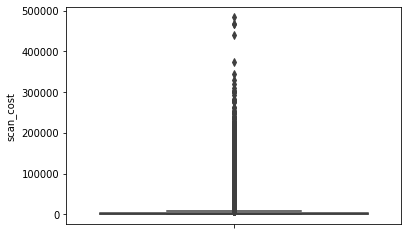

In [29]:
df_scan_cost = df.scan_cost.values
sns.boxplot(y='scan_cost',data=df)
plt.show()

In [0]:
quartile1 = data.scan_cost.quantile(0.25)
quartile3 = data.scan_cost.quantile(0.75)
IQR = quartile3 - quartile1   

lower_limit =  quartile1 - 1.5 * IQR
upper_limit = quartile3 + 1.5 *IQR

upper_cap = data.scan_cost.quantile(0.75)
lower_cap = data.scan_cost.quantile(0.25)

df.loc[df.scan_cost > upper_limit,'scan_cost'] = upper_cap
df.loc[df.scan_cost < lower_limit,'scan_cost'] = lower_cap

### Plot after outlier treatment

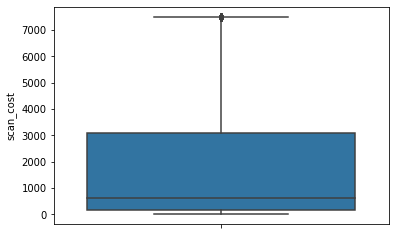

In [31]:
df_scan_cost = df.scan_cost.values
sns.boxplot(y='scan_cost',data=df)
plt.show()

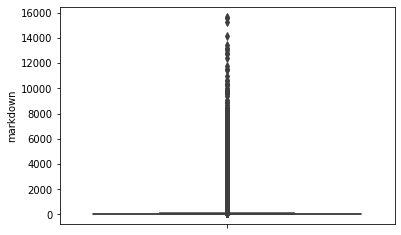

In [32]:
sns.boxplot(y="markdown",data=df)

In [0]:
quartile1 = data.markdown.quantile(0.25)
quartile3 = data.markdown.quantile(0.75)
IQR = quartile3 - quartile1   

lower_limit =  quartile1 - 1.5 * IQR
upper_limit = quartile3 + 1.5 *IQR

upper_cap = df.markdown.quantile(0.75)
lower_cap = df.markdown.quantile(0.25)

df.loc[df.markdown > upper_limit,'markdown'] = upper_cap
df.loc[df.markdown < lower_limit,'markdown'] = lower_cap

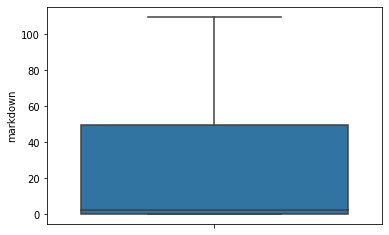

In [34]:
sns.boxplot(y="markdown",data=df)

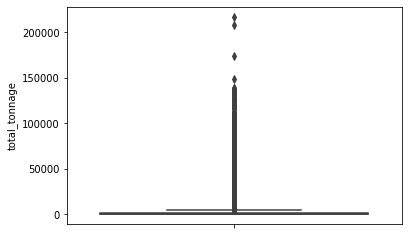

In [35]:
sns.boxplot(y = 'total_tonnage',data=df)

In [0]:
Q1 = df.total_tonnage.quantile(0.25)
Q3 = df.total_tonnage.quantile(0.75)
IQR = Q3 - Q1   

lower_limit =  Q1 - 1.5 * IQR
upper_limit = Q3 + 1.5 *IQR

upper_cap = df.total_tonnage.quantile(0.75)
lower_cap = df.total_tonnage.quantile(0.25)
df.loc[df.total_tonnage > upper_limit,'total_tonnage'] =  upper_cap
df.loc[df.total_tonnage < lower_limit,'total_tonnage'] = lower_cap

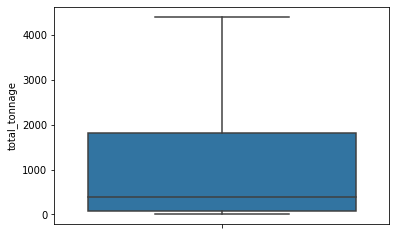

In [37]:
sns.boxplot(y = 'total_tonnage',data=df)

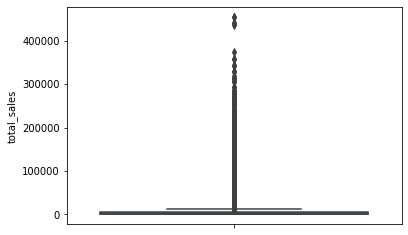

In [38]:
sns.boxplot(y='total_sales',data=df)

In [0]:
Q1 = df.total_sales.quantile(0.25)
Q3 = df.total_sales.quantile(0.75)
IQR = Q3 - Q1   

lower_limit =  Q1 - 1.5 * IQR
upper_limit = Q3 + 1.5 *IQR

upper_cap = df.total_sales.quantile(0.75)
lower_cap = df.total_sales.quantile(0.25)

df.loc[df.total_sales > upper_limit,'total_sales'] = upper_cap 
df.loc[df.total_sales < lower_limit,'total_sales'] = lower_cap

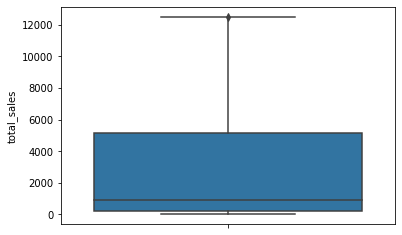

In [40]:
sns.boxplot(y='total_sales',data=df)

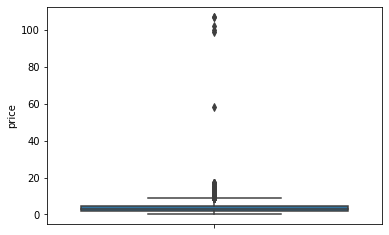

In [41]:
sns.boxplot(y='price',data=df)

In [0]:
Q1 = df.price.quantile(0.25)
Q3 = df.price.quantile(0.75)
IQR = Q3 - Q1   

lower_limit =  Q1 - 1.5 * IQR
upper_limit = Q3 + 1.5 *IQR

upper_cap = df.price.quantile(0.75)
lower_cap = df.price.quantile(0.25)

df.loc[df.price > upper_limit,'price'] = upper_cap 
df.loc[df.price < lower_limit,'price'] = lower_cap

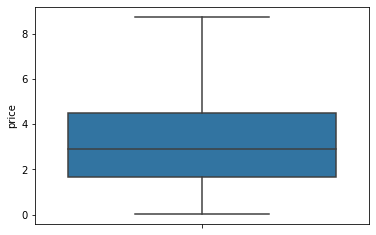

In [43]:
sns.boxplot(y='price',data=df)

### Adding New Variables ACV , Margin, Per_tonnage_markdown,List_price

In [0]:
df['ACV'] = df['num_of_stores_on_promotion'] / df["Number of stores"]
df['Markdown_Per_Tonnage'] = df['markdown'] / df['total_tonnage']
df['Scan_Cost_Per_Tonnage'] = df['scan_cost'] / df['total_tonnage']
df['Profit'] = df['total_sales'] - df['scan_cost']
df['Profit_Per_Tonnage'] = df['Profit'] / df['total_tonnage']
df['Profit_Margin'] = df['Profit_Per_Tonnage'] / df['Scan_Cost_Per_Tonnage']
df['List_price'] = df['Markdown_Per_Tonnage'] / df['total_tonnage']
df['Markdown_Percentage'] = df['Markdown_Per_Tonnage'] / df['List_price']

### univariate analysis and graphs, bi variate analysis and graphs

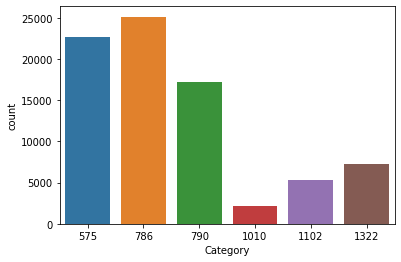

In [0]:
sns.countplot(x="Category", data=df)

2017    29988
2018    27813
2019    21913
Name: Year, dtype: int64


Text(0.5, 1.0, 'Count of Year')

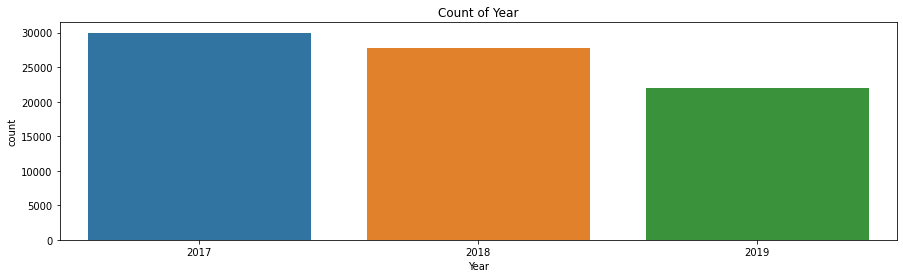

In [0]:
plt.figure(figsize=(15,4))
print(df['Year'].value_counts())
sns.countplot("Year",data = df)
plt.title("Count of Year")

Tues     54854
Sat       5649
Sun       5623
Thurs     3804
Fri       3678
Mon       3285
Weds      2821
Name: DayofWeek, dtype: int64


Text(0.5, 1.0, 'Count of days in week')

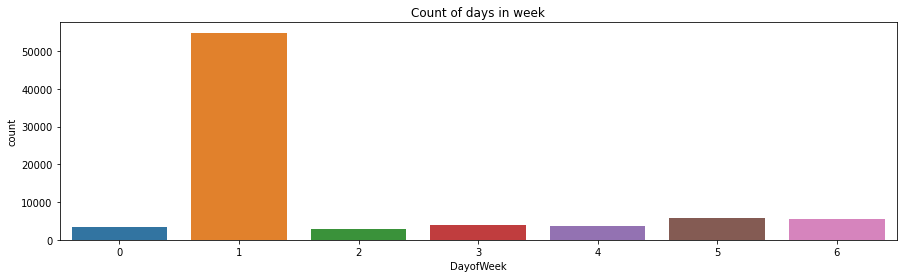

In [0]:
days = {0:'Mon',1:'Tues',2:'Weds',3:'Thurs',4:'Fri',5:'Sat',6:'Sun'}
plt.figure(figsize=(15,4))
print(df['DayofWeek'].apply(lambda x : days[x]).value_counts())
sns.countplot("DayofWeek",data = df)
plt.title("Count of days in week")

In [0]:
# sns.countplot(x=df['Category'], hue=df['promos'], data=df)

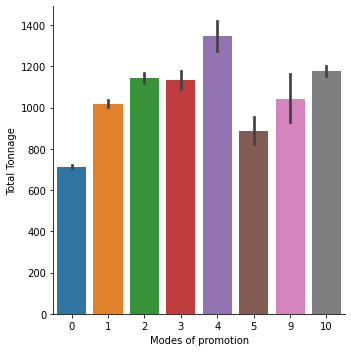

In [0]:
sns.catplot(x="mechanism of promotion", y="total_tonnage", data=df, kind='bar')
plt.ylabel("Total Tonnage")
plt.xlabel("Modes of promotion")
plt.show()

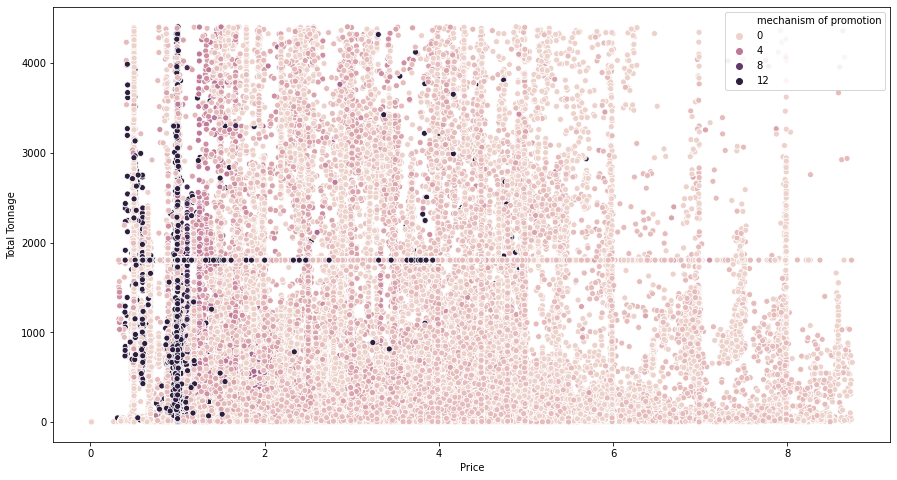

In [0]:
plt.figure(figsize=(15,8))
sns.scatterplot(x="price",y="total_tonnage", hue='mechanism of promotion', data=df)
plt.xlabel("Price")
plt.ylabel("Total Tonnage")
plt.show()

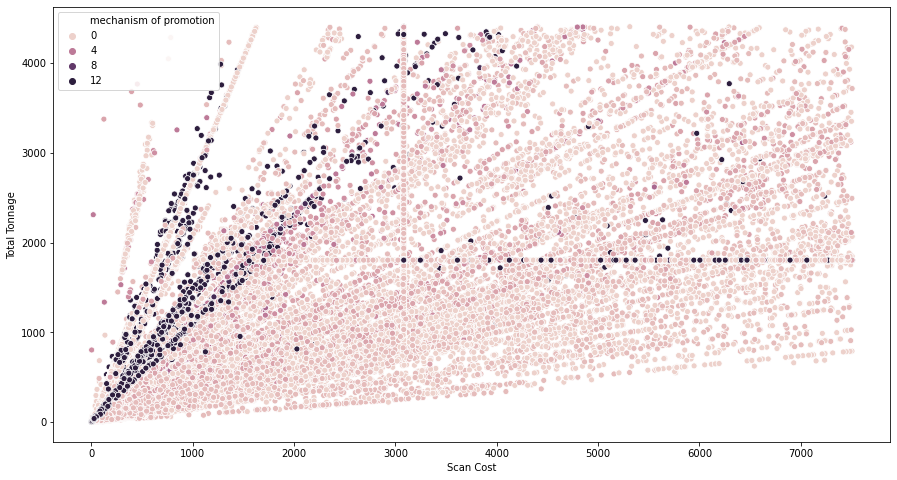

In [0]:
plt.figure(figsize=(15,8))
sns.scatterplot(x="scan_cost",y="total_tonnage", hue='mechanism of promotion', data=df)
plt.xlabel("Scan Cost")
plt.ylabel("Total Tonnage")
plt.show()

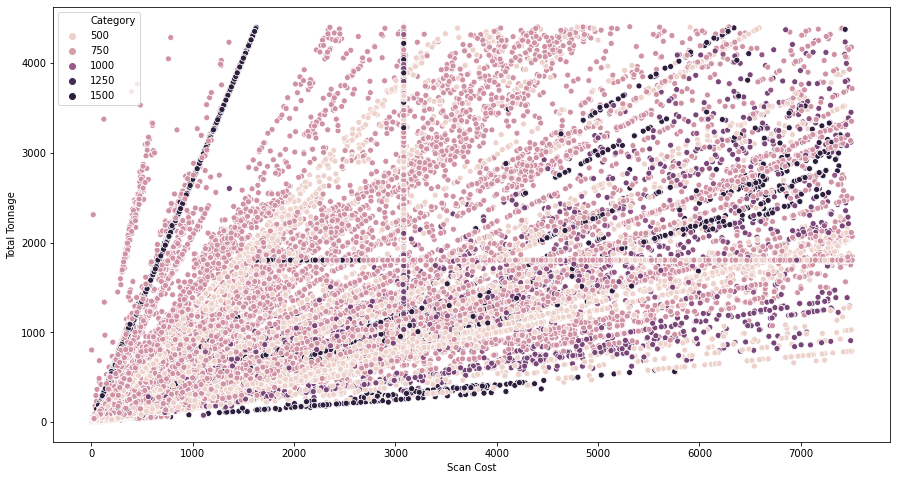

In [0]:
plt.figure(figsize=(15,8))
sns.scatterplot(x="scan_cost",y="total_tonnage", hue='Category', data=df)
plt.xlabel("Scan Cost")
plt.ylabel("Total Tonnage")
plt.show()

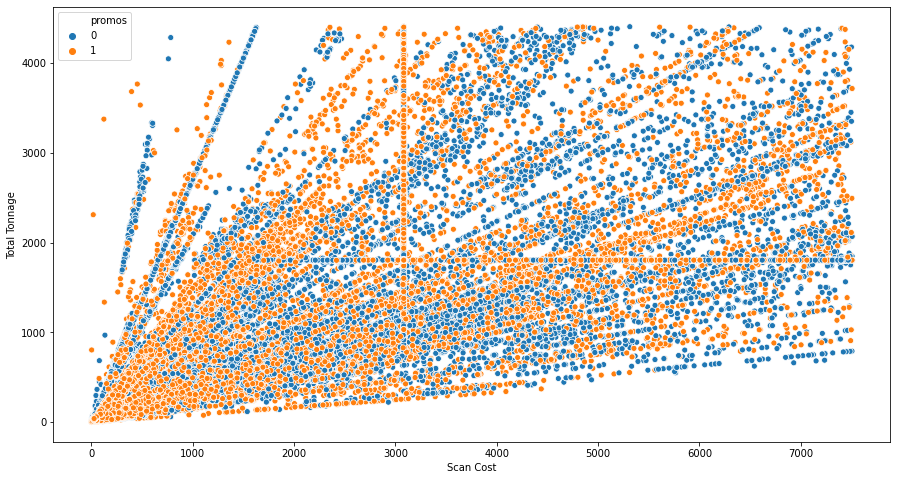

In [0]:
plt.figure(figsize=(15,8))
sns.scatterplot(x="scan_cost",y="total_tonnage", hue='promos', data=df)
plt.xlabel("Scan Cost")
plt.ylabel("Total Tonnage")
plt.show()

Text(0.5, 1.0, 'Mechanism of Promotion vs Week')

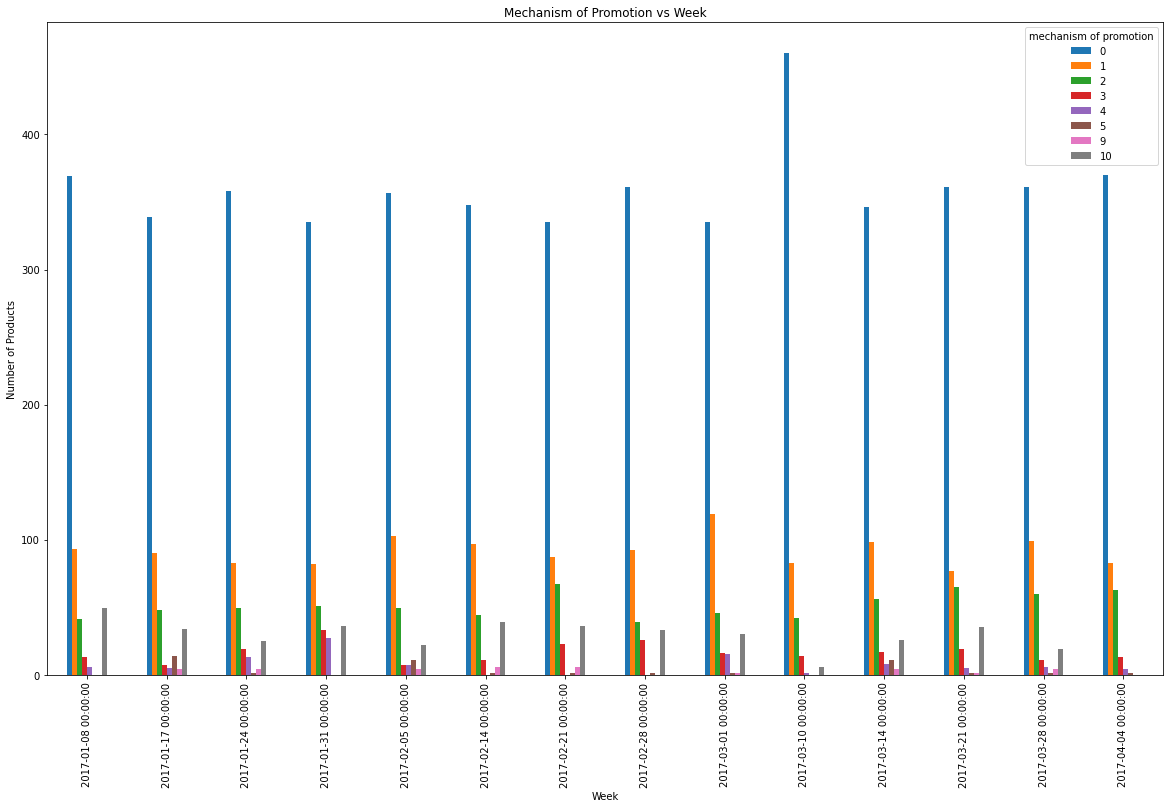

In [0]:
df_promo= df.groupby(["AD_WEEK_ENDING_DATE","mechanism of promotion"]).count()["Group Id"]
fig,ax = plt.subplots(figsize=(20,12))
df_promo.head(100).unstack().plot(ax =ax,kind="bar")
plt.xlabel("Week")
plt.ylabel("Number of Products")
plt.title("Mechanism of Promotion vs Week")

Text(0.5, 1.0, 'Price vs Week')

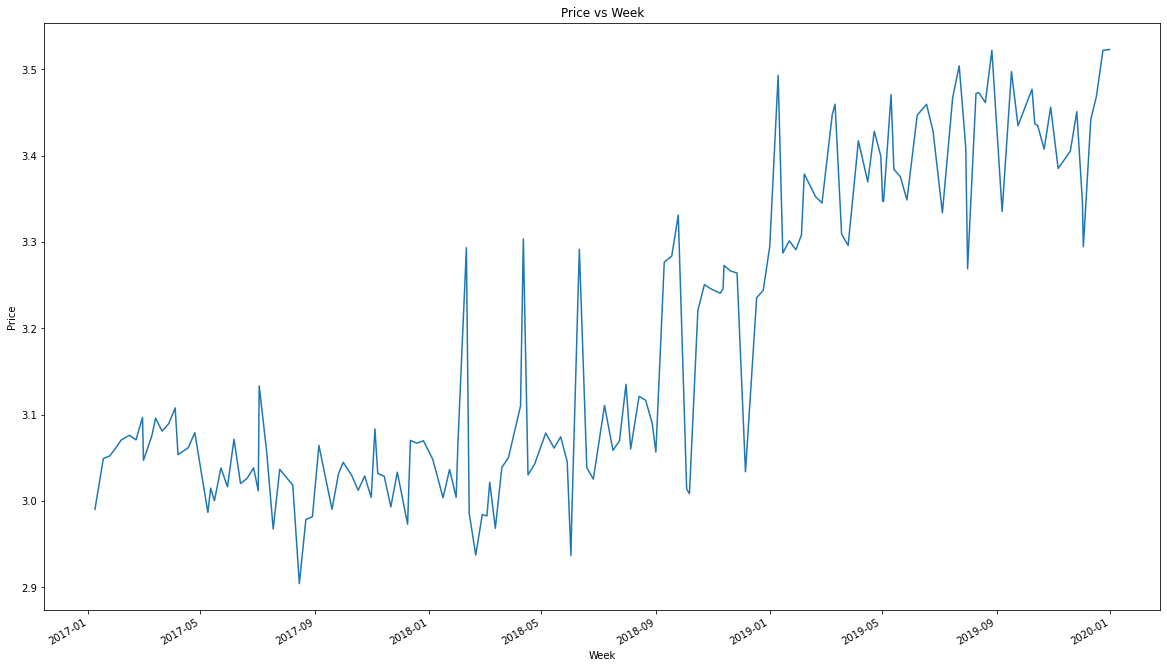

In [0]:
df_price = df.groupby(["AD_WEEK_ENDING_DATE"]).mean()["price"]
fig,ax = plt.subplots(figsize=(20,12))
df_price.plot(ax =ax)
plt.xlabel("Week")
plt.ylabel("Price")
plt.title("Price vs Week")

Text(0.5, 1.0, 'Cost vs Week')

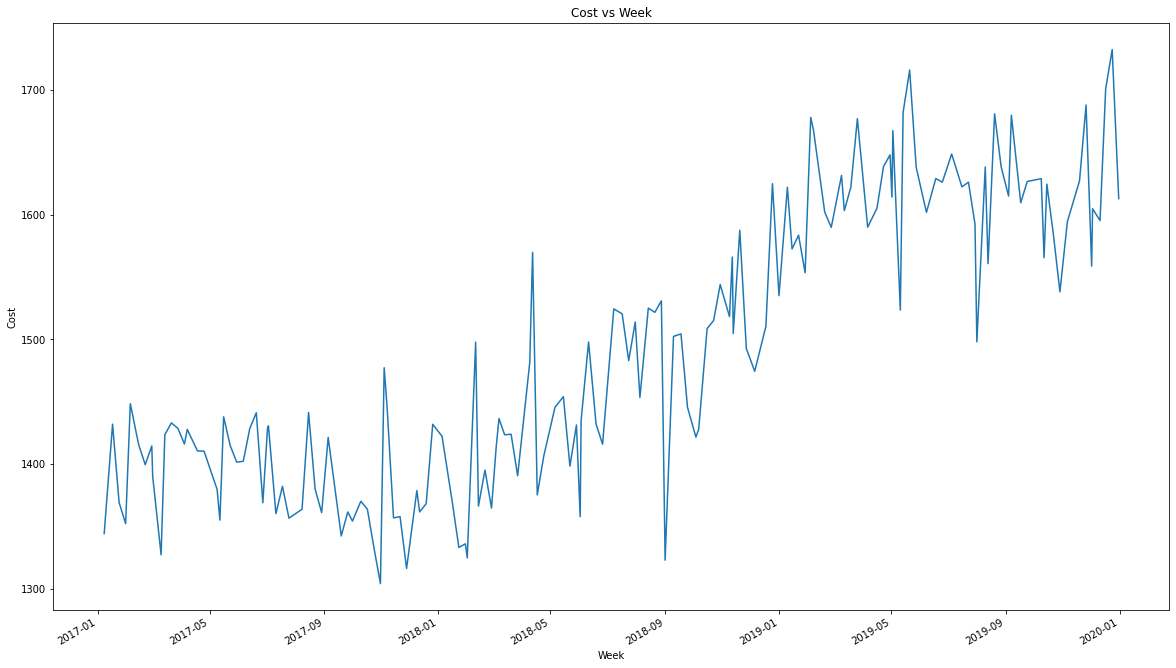

In [0]:
df_cost = df.groupby(["AD_WEEK_ENDING_DATE"]).mean()["scan_cost"]
fig,ax = plt.subplots(figsize=(20,12))
df_cost.plot(ax =ax)
plt.xlabel("Week")
plt.ylabel("Cost")
plt.title("Cost vs Week")

Text(0.5, 1.0, 'Tonnage vs Week')

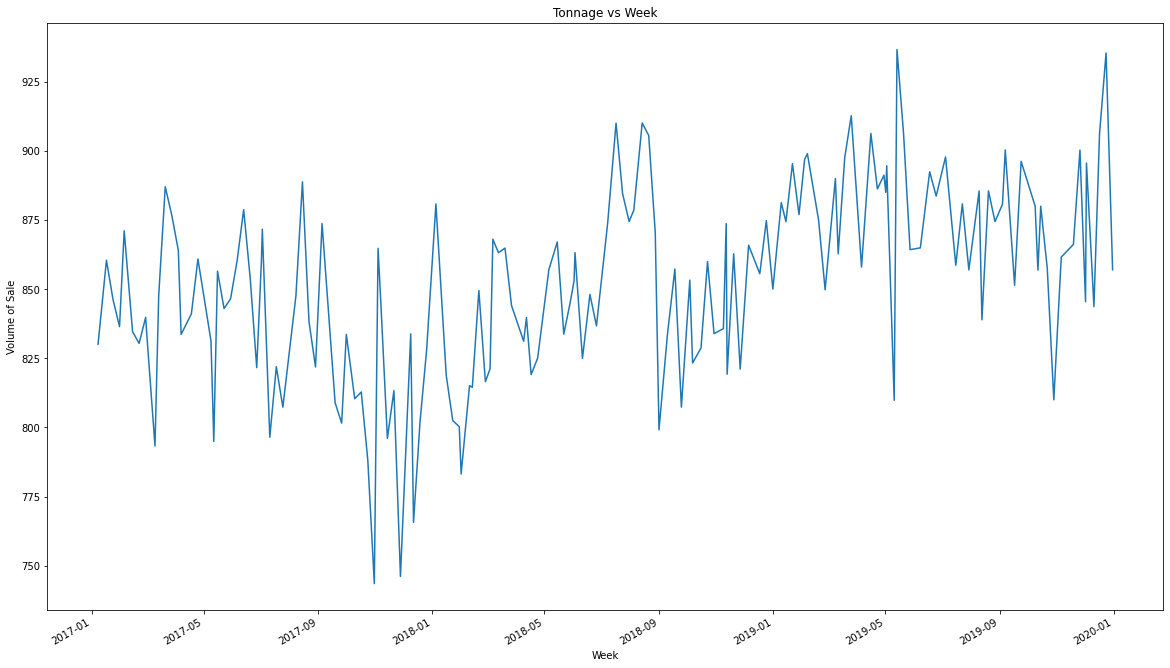

In [0]:
df_tonnage = df.groupby(["AD_WEEK_ENDING_DATE"]).mean()["total_tonnage"]
fig,ax = plt.subplots(figsize=(20,12))
df_tonnage.plot(ax =ax)
plt.xlabel("Week")
plt.ylabel("Volume of Sale")
plt.title("Tonnage vs Week")

In [0]:
# df_weekend.first().head()

In [0]:
df_decompose = df.groupby("AD_WEEK_ENDING_DATE").mean()["total_sales"]
df_decompose.head()

AD_WEEK_ENDING_DATE
2017-01-08    2141.661020
2017-01-17    2204.988119
2017-01-24    2210.670018
2017-01-31    2176.116104
2017-02-05    2290.647670
Name: total_sales, dtype: float64

In [0]:
from statsmodels.tsa.seasonal import seasonal_decompose

In [0]:
result = seasonal_decompose(df_decompose,model="additive",freq=2)

Text(0.5, 1.0, 'Trend')

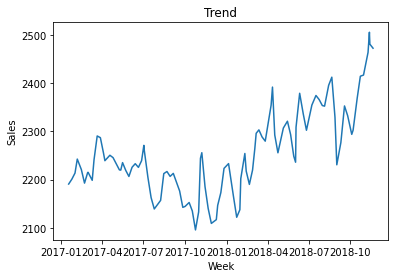

In [0]:
plt.plot(result.trend.head(100))
plt.xlabel("Week")
plt.ylabel("Sales")
plt.title("Trend")

Text(0.5, 1.0, 'Seasonality')

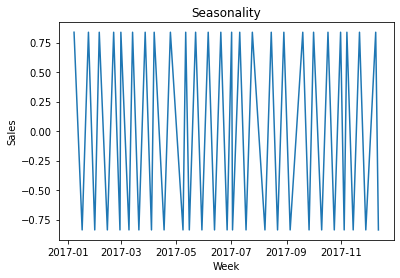

In [0]:
plt.plot(result.seasonal.head(50))
plt.xlabel("Week")
plt.ylabel("Sales")
plt.title("Seasonality")

Text(0.5, 1.0, 'Residual')

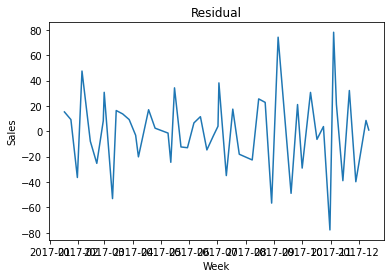

In [0]:
plt.plot(result.resid.head(50))
plt.xlabel("Week")
plt.ylabel("Sales")
plt.title("Residual")

In [0]:
df_753 = df[df["Group Id"] == 753]

In [0]:
df_season = df_753.groupby('AD_WEEK_ENDING_DATE').agg({"total_tonnage":"mean"})

Text(0.5, 1.0, 'Tonnage over weeks')

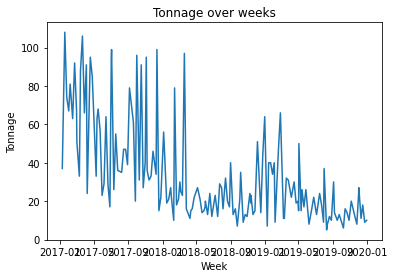

In [0]:
plt.plot(df_season["total_tonnage"])
plt.xlabel("Week")
plt.ylabel("Tonnage")
plt.title("Tonnage over weeks")

In [0]:
df_season.head(67)

,total_tonnage
AD_WEEK_ENDING_DATE,
2017-01-08,37.0
2017-01-17,108.0
2017-01-24,74.0
2017-01-31,67.0
2017-02-05,81.0
...,...
2018-03-07,25.0
2018-03-13,23.0
2018-03-20,97.0


In [0]:
import statsmodels.api as sm

In [0]:
mod = sm.tsa.statespace.SARIMAX(df_season,
                                order=(0, 1, 1),
                                seasonal_order=(0, 1, 1, 7),
                                enforce_stationarity=False,
                                enforce_invertibility=False)
results = mod.fit()
print(results.summary().tables[1])

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -1.1151      0.052    -21.639      0.000      -1.216      -1.014
ma.S.L7       -1.0000   1098.645     -0.001      0.999   -2154.306    2152.306
sigma2       312.2230   3.43e+05      0.001      0.999   -6.72e+05    6.73e+05


/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


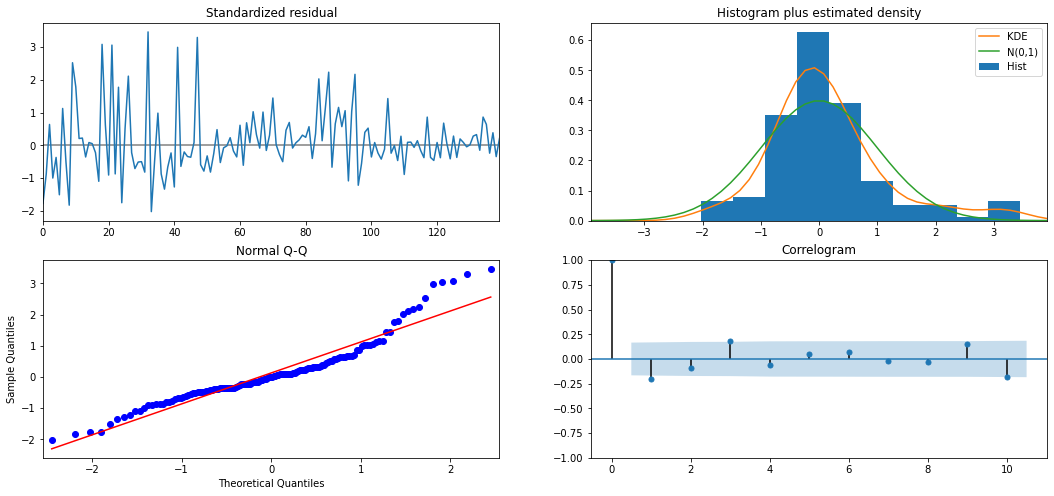

In [0]:
results.plot_diagnostics(figsize=(18, 8))
plt.show()

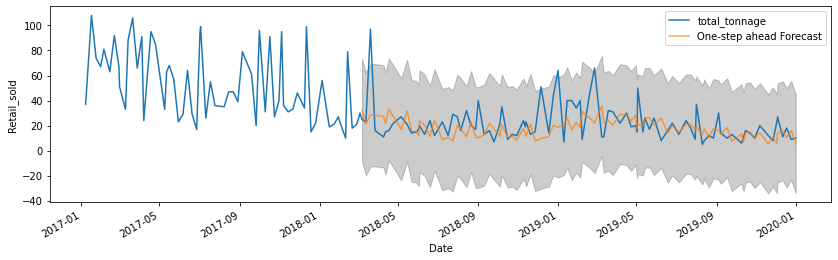

In [0]:
pred = results.get_prediction(start=pd.to_datetime('2018-03-07'), dynamic=False)
pred_ci = pred.conf_int()
ax = df_season['2017':].plot(label='observed')
pred.predicted_mean.plot(ax=ax, label='One-step ahead Forecast', alpha=.7, figsize=(14, 4))
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.2)
ax.set_xlabel('Date')
ax.set_ylabel('Retail_sold')
plt.legend()
plt.show()

In [0]:
y_forecasted = pred.predicted_mean
y_truth = df_season['2018-03-07':]
mse = ((y_forecasted - y_truth["total_tonnage"]) ** 2).mean()
print('The Mean Squared Error is {}'.format(round(mse, 2)))
print('The Root Mean Squared Error is {}'.format(round(np.sqrt(mse), 2)))

The Mean Squared Error is 229.22
The Root Mean Squared Error is 15.14


In [0]:
df.columns

Index(['Group Id', 'AD_WEEK_ENDING_DATE', 'Category', 'Number of stores',
       'markdown', 'scan_cost', 'promos', 'print_ad', 'digital_ad',
       'instore_ad', 'mechanism of promotion', 'national_brand',
       'total_tonnage', 'total_sales', 'price', 'num_of_stores_on_promotion',
       'Month', 'DayofWeek', 'Year', 'Number of Week', 'ACV',
       'Markdown_Per_Tonnage', 'Scan_Cost_Per_Tonnage', 'Profit',
       'Profit_Per_Tonnage', 'Profit_Margin', 'List_price',
       'Markdown_Percentage'],
      dtype='object')

In [0]:
train_data = df.iloc[:,:]

In [46]:
train_data.isnull().sum()/len(train_data)*100

Group Id                       0.00000
AD_WEEK_ENDING_DATE            0.00000
Category                       0.00000
Number of stores               0.00000
markdown                       0.00000
scan_cost                      0.00000
promos                         0.00000
print_ad                       0.00000
digital_ad                     0.00000
instore_ad                     0.00000
mechanism of promotion         0.00000
national_brand                 0.00000
total_tonnage                  0.00000
total_sales                    0.00000
price                          0.00000
num_of_stores_on_promotion     0.00000
Month                          0.00000
DayofWeek                      0.00000
Year                           0.00000
Number of Week                 0.00000
ACV                            0.00000
Markdown_Per_Tonnage           0.00000
Scan_Cost_Per_Tonnage          0.00000
Profit                         0.00000
Profit_Per_Tonnage             0.00000
Profit_Margin            

In [0]:
dfc = train_data.drop(['Markdown_Percentage'],axis=1)

In [0]:
train_data = train_data.drop(['total_tonnage','AD_WEEK_ENDING_DATE','Markdown_Percentage'], axis=1)

In [0]:
train_labels = df['total_tonnage'].values

In [50]:
train_data.shape

(79714, 25)

In [0]:
train_labels.shape

(79714,)

In [0]:
train_data.corr()

,Group Id,Category,Number of stores,markdown,scan_cost,promos,print_ad,digital_ad,instore_ad,mechanism of promotion,national_brand,total_sales,price,num_of_stores_on_promotion,Month,DayofWeek,Year,Number of Week,ACV,Markdown_Per_Tonnage,Scan_Cost_Per_Tonnage,Profit,Profit_Per_Tonnage,Profit_Margin,List_price
Group Id,1.000000,0.086449,-0.054487,0.011075,-0.107711,0.006563,-0.027657,-0.000941,0.021947,0.013250,0.003685,-0.104275,0.048547,-0.033801,0.001111,0.001072,-0.023530,0.002277,0.008586,-0.002203,0.048241,-0.077968,0.049915,-0.005864,-0.002395
Category,0.086449,1.000000,0.044000,-0.025520,0.075864,-0.116536,-0.116079,-0.038205,-0.061079,-0.108056,-0.252922,0.088423,-0.014871,-0.311457,-0.031146,0.014371,-0.130169,-0.028865,-0.394217,0.008131,-0.106458,0.084095,0.086603,0.029681,0.008261
Number of stores,-0.054487,0.044000,1.000000,0.418539,0.723555,0.300909,0.184522,0.087216,0.222793,0.227465,-0.139884,0.713020,-0.071332,0.654116,0.000392,-0.006795,0.044779,0.000880,-0.687858,-0.013724,-0.195284,0.548202,0.065019,0.045992,-0.007865
markdown,0.011075,-0.025520,0.418539,1.000000,0.281088,0.720465,0.326736,0.167851,0.582092,0.473364,-0.024728,0.265476,-0.014979,0.442434,-0.003543,-0.002045,0.033914,-0.001798,-0.149286,0.024649,-0.024133,0.190526,0.018686,0.015040,0.017543
scan_cost,-0.107711,0.075864,0.723555,0.281088,1.000000,0.176063,0.111580,0.043489,0.131440,0.058877,-0.227857,0.915579,0.133703,0.357342,0.007773,-0.001964,0.052252,0.006745,-0.591791,-0.010328,0.084266,0.621562,0.150498,0.025862,-0.005164
promos,0.006563,-0.116536,0.300909,0.720465,0.176063,1.000000,0.379305,0.171973,0.847946,0.583755,0.088672,0.164434,-0.082542,0.391957,-0.006616,0.004868,0.012426,-0.004813,-0.014740,0.001124,-0.022293,0.115735,-0.071425,-0.009642,-0.004528
print_ad,-0.027657,-0.116079,0.184522,0.326736,0.111580,0.379305,1.000000,0.002152,-0.039859,0.274130,0.055389,0.098503,-0.089464,0.240371,0.019807,-0.005299,0.030120,0.022522,-0.006132,-0.000568,-0.049195,0.062230,-0.050616,-0.009519,-0.001727
digital_ad,-0.000941,-0.038205,0.087216,0.167851,0.043489,0.171973,0.002152,1.000000,-0.025878,0.132685,0.036216,0.045174,-0.042103,0.118549,0.009295,0.001025,0.042807,0.009067,-0.000048,-0.000253,-0.031628,0.037466,-0.015043,-0.000423,-0.000784
instore_ad,0.021947,-0.061079,0.222793,0.582092,0.131440,0.847946,-0.039859,-0.025878,1.000000,0.477255,0.062763,0.124841,-0.040274,0.288073,-0.019342,0.004210,-0.013426,-0.018585,-0.014326,0.001370,0.004601,0.090459,-0.047460,-0.005357,-0.003836
mechanism of promotion,0.013250,-0.108056,0.227465,0.473364,0.058877,0.583755,0.274130,0.132685,0.477255,1.000000,0.103991,0.051605,-0.296490,0.334817,-0.001689,0.005782,-0.046609,-0.000006,0.022139,-0.001104,-0.183490,0.032113,-0.107204,-0.008429,-0.002660


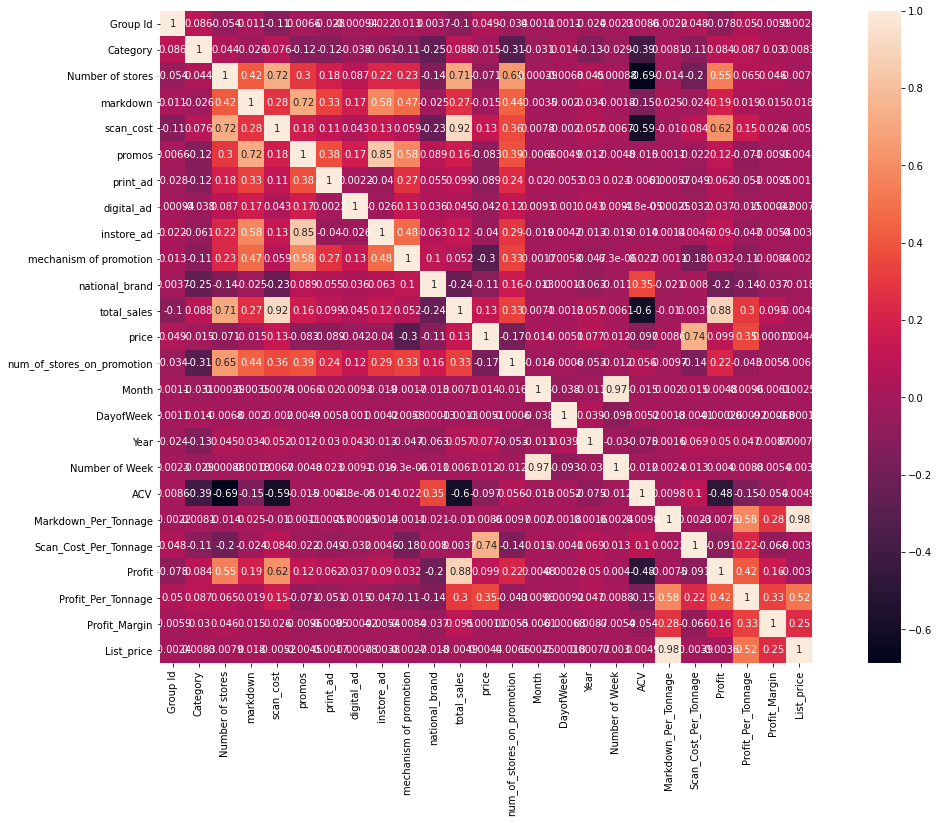

In [0]:
corr = train_data.corr()
plt.figure(figsize=(20,12))
sns.heatmap(corr,square=True,annot=True)

## Regression Model

In [0]:
sc = StandardScaler()

In [0]:
train_data = sc.fit_transform(train_data)

In [0]:
y = sc.fit_transform(train_labels.reshape(-1,1))

In [0]:
x_train,x_test,y_train,y_test = train_test_split(train_data,y)

In [0]:
reg = LinearRegression()

In [0]:
reg.fit(x_train,y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [0]:
y_pred = reg.predict(x_test)

In [0]:
# Mean Squared Error
mean_squared_error(y_test, y_pred)

0.2518341797854589

In [0]:
# R Squared
r2_score(y_test,y_pred)

0.7528507735496877

In [0]:
# Mean Absolute Error
mean_absolute_error(y_test,y_pred)

0.3061400508861449

In [0]:
# RMSE
np.sqrt(mean_absolute_error(y_test,y_pred))

0.5532992417183895

In [0]:
#To retrieve the intercept
print(reg.intercept_)
#For retrieving the slope
print(reg.coef_)

[-0.00106251]
[[-2.86373345e-02  6.50019460e-02  3.53025176e-01 -1.21943066e-02
   3.18530347e-01 -5.53078080e-03  1.85480445e-03  1.89885555e-03
  -8.73949175e-03  2.88805411e-02 -3.60458250e-02  2.60134645e-01
   1.45354227e-01 -9.10525113e-02  2.82458920e-04  8.78727648e-04
  -5.89530596e-03 -2.85359704e-03  1.02846113e-01  4.80885604e-01
  -2.81486894e-01  1.36614678e-01 -2.78754451e-01  9.59713898e-02
  -3.87440369e-01]]


In [0]:
from statsmodels.api import OLS

In [0]:
# Training Results
OLS(y_train,x_train).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                      y   R-squared (uncentered):                   0.786
Model:                            OLS   Adj. R-squared (uncentered):              0.786
Method:                 Least Squares   F-statistic:                              9163.
Date:                Wed, 13 May 2020   Prob (F-statistic):                        0.00
Time:                        18:39:35   Log-Likelihood:                         -38509.
No. Observations:               59785   AIC:                                  7.707e+04
Df Residuals:                   59761   BIC:                                  7.728e+04
Df Model:                          24                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1            -0.0286      0.002    -14.901      0.000      -0.032      -0.025
x2             0.0650      0.002     28.283      0.000       0.061       0.070
x3             0.3530      0.010     35.219      0.000       0.333       0.373
x4            -0.0122      0.003     -4.112      0.000      -0.018      -0.006
x5             0.3185      0.003    109.022      0.000       0.313       0.324
x6            -0.0055      0.007     -0.760      0.447      -0.020       0.009
x7             0.0019      0.003      0.534      0.593      -0.005       0.009
x8             0.0019      0.002      0.812      0.417      -0.003       0.006
x9            -0.0087      0.006     -1.373      0.170      -0.021       0.004
x10            0.0289      0.002     11.598      0.000       0.024       0.034
x11           -0.0360      0.002    -17.256      0.000      -0.040      -0.032
x12            0.2601      0.001    207.668      0.000       0.258       0.263
x13            0.1454      0.003     45.005      0.000       0.139       0.152
x14           -0.0910      0.007    -13.280      0.000      -0.104      -0.078
x15            0.0003      0.008      0.037      0.971      -0.015       0.016
x16            0.0009      0.002      0.452      0.652      -0.003       0.005
x17           -0.0059      0.002     -2.994      0.003      -0.010      -0.002
x18           -0.0029      0.008     -0.356      0.722      -0.019       0.013
x19            0.1028      0.007     14.120      0.000       0.089       0.117
x20            0.4808      0.012     39.579      0.000       0.457       0.505
x21           -0.2815      0.003    -87.020      0.000      -0.288      -0.275
x22            0.1366      0.003     44.692      0.000       0.131       0.143
x23           -0.2788      0.004    -74.004      0.000      -0.286      -0.271
x24            0.0960      0.005     17.972      0.000       0.086       0.106
x25           -0.3874      0.013    -30.161      0.000      -0.413      -0.362
==============================================================================
Omnibus:                    35930.403   Durbin-Watson:                   1.993
Prob(Omnibus):                  0.000   Jarque-Bera (JB):          1012078.121
Skew:                           2.403   Prob(JB):                         0.00
Kurtosis:                      22.575   Cond. No.                     7.48e+15
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 4.92e-27. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

In [0]:
# Testing Results
OLS(y_test,x_test).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                      y   R-squared (uncentered):                   0.790
Model:                            OLS   Adj. R-squared (uncentered):              0.789
Method:                 Least Squares   F-statistic:                              3114.
Date:                Wed, 13 May 2020   Prob (F-statistic):                        0.00
Time:                        18:39:35   Log-Likelihood:                         -12929.
No. Observations:               19929   AIC:                                  2.591e+04
Df Residuals:                   19905   BIC:                                  2.610e+04
Df Model:                          24                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1            -0.0248      0.003     -7.301      0.000      -0.031      -0.018
x2             0.0786      0.004     19.843      0.000       0.071       0.086
x3             0.2950      0.017     16.976      0.000       0.261       0.329
x4            -0.0127      0.005     -2.455      0.014      -0.023      -0.003
x5             0.2826      0.005     54.032      0.000       0.272       0.293
x6            -0.0199      0.013     -1.558      0.119      -0.045       0.005
x7             0.0045      0.006      0.729      0.466      -0.008       0.016
x8            -0.0030      0.004     -0.743      0.457      -0.011       0.005
x9            -0.0061      0.011     -0.545      0.586      -0.028       0.016
x10            0.0230      0.004      5.305      0.000       0.014       0.031
x11           -0.0345      0.004     -9.540      0.000      -0.042      -0.027
x12            0.2734      0.002    123.559      0.000       0.269       0.278
x13            0.1702      0.006     30.741      0.000       0.159       0.181
x14           -0.0412      0.012     -3.469      0.001      -0.064      -0.018
x15            0.0086      0.013      0.669      0.504      -0.017       0.034
x16            0.0012      0.003      0.357      0.721      -0.005       0.008
x17           -0.0002      0.003     -0.071      0.943      -0.007       0.006
x18           -0.0107      0.013     -0.830      0.406      -0.036       0.015
x19            0.0647      0.013      5.142      0.000       0.040       0.089
x20            0.3406      0.144      2.369      0.018       0.059       0.622
x21           -0.2735      0.006    -48.341      0.000      -0.285      -0.262
x22            0.2043      0.006     35.284      0.000       0.193       0.216
x23           -0.3645      0.008    -48.339      0.000      -0.379      -0.350
x24            0.0011      0.002      0.583      0.560      -0.003       0.005
x25           -0.1594      0.127     -1.258      0.208      -0.408       0.089
==============================================================================
Omnibus:                     8852.051   Durbin-Watson:                   1.990
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            48663.693
Skew:                           2.107   Prob(JB):                         0.00
Kurtosis:                       9.391   Cond. No.                     5.49e+15
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 3.49e-27. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

In [0]:
# Mean Squared Error
mse = mean_squared_error(y_test, y_pred)
# R Squared
r2 = r2_score(y_test,y_pred)
# Mean Absolute Error
mae = mean_absolute_error(y_test,y_pred)
# RMSE
rmse = np.sqrt(mean_absolute_error(y_test,y_pred))
#To retrieve the intercept
intercept = reg.intercept_
#For retrieving the slope
coef = reg.coef_

In [0]:
{'MSE':[mse],'r2':[r2],'mae':[mae],'mse':[mse],'rmse':[rmse],'intercept':[intercept],'coef':coef[0]}

{'MSE': [0.2518341797854589],
 'coef': array([-2.86373345e-02,  6.50019460e-02,  3.53025176e-01, -1.21943066e-02,
         3.18530347e-01, -5.53078080e-03,  1.85480445e-03,  1.89885555e-03,
        -8.73949175e-03,  2.88805411e-02, -3.60458250e-02,  2.60134645e-01,
         1.45354227e-01, -9.10525113e-02,  2.82458920e-04,  8.78727648e-04,
        -5.89530596e-03, -2.85359704e-03,  1.02846113e-01,  4.80885604e-01,
        -2.81486894e-01,  1.36614678e-01, -2.78754451e-01,  9.59713898e-02,
        -3.87440369e-01]),
 'intercept': [array([-0.00106251])],
 'mae': [0.3061400508861449],
 'mse': [0.2518341797854589],
 'r2': [0.7528507735496877],
 'rmse': [0.5532992417183895]}

In [0]:
summary_df = pd.DataFrame({'MSE':[mse],'r2':[r2],'mae':[mae],'mse':[mse],'rmse':[rmse],'intercept':intercept})

In [0]:
summary_df.to_csv('summary.csv')

In [0]:
coef_df = pd.DataFrame(coef[0])

In [0]:
coef_df.columns = ['coef']

In [0]:
coef_df.to_csv('coef.csv')

## Updated Category Level Regression Model

In [0]:
df_filter = dfc.drop(["Group Id","AD_WEEK_ENDING_DATE","Year","Number of Week","Month","DayofWeek","Category"],axis=1)

In [0]:
df_filter.corr()

,Number of stores,markdown,scan_cost,promos,print_ad,digital_ad,instore_ad,mechanism of promotion,national_brand,total_tonnage,total_sales,price,num_of_stores_on_promotion,ACV,Markdown_Per_Tonnage,Scan_Cost_Per_Tonnage,Profit,Profit_Per_Tonnage,Profit_Margin,List_price
Number of stores,1.000000,0.418539,0.723555,0.300909,0.184522,0.087216,0.222793,0.227465,-0.139884,0.748813,0.713020,-0.071332,0.654116,-0.687858,-0.013724,-0.195284,0.548202,0.065019,0.045992,-0.007865
markdown,0.418539,1.000000,0.281088,0.720465,0.326736,0.167851,0.582092,0.473364,-0.024728,0.273750,0.265476,-0.014979,0.442434,-0.149286,0.024649,-0.024133,0.190526,0.018686,0.015040,0.017543
scan_cost,0.723555,0.281088,1.000000,0.176063,0.111580,0.043489,0.131440,0.058877,-0.227857,0.770172,0.915579,0.133703,0.357342,-0.591791,-0.010328,0.084266,0.621562,0.150498,0.025862,-0.005164
promos,0.300909,0.720465,0.176063,1.000000,0.379305,0.171973,0.847946,0.583755,0.088672,0.182118,0.164434,-0.082542,0.391957,-0.014740,0.001124,-0.022293,0.115735,-0.071425,-0.009642,-0.004528
print_ad,0.184522,0.326736,0.111580,0.379305,1.000000,0.002152,-0.039859,0.274130,0.055389,0.121460,0.098503,-0.089464,0.240371,-0.006132,-0.000568,-0.049195,0.062230,-0.050616,-0.009519,-0.001727
digital_ad,0.087216,0.167851,0.043489,0.171973,0.002152,1.000000,-0.025878,0.132685,0.036216,0.055234,0.045174,-0.042103,0.118549,-0.000048,-0.000253,-0.031628,0.037466,-0.015043,-0.000423,-0.000784
instore_ad,0.222793,0.582092,0.131440,0.847946,-0.039859,-0.025878,1.000000,0.477255,0.062763,0.129863,0.124841,-0.040274,0.288073,-0.014326,0.001370,0.004601,0.090459,-0.047460,-0.005357,-0.003836
mechanism of promotion,0.227465,0.473364,0.058877,0.583755,0.274130,0.132685,0.477255,1.000000,0.103991,0.129517,0.051605,-0.296490,0.334817,0.022139,-0.001104,-0.183490,0.032113,-0.107204,-0.008429,-0.002660
national_brand,-0.139884,-0.024728,-0.227857,0.088672,0.055389,0.036216,0.062763,0.103991,1.000000,-0.224849,-0.236108,-0.105065,0.155886,0.351993,-0.020960,0.008037,-0.195171,-0.135011,-0.037064,-0.018307
total_tonnage,0.748813,0.273750,0.770172,0.182118,0.121460,0.055234,0.129863,0.129517,-0.224849,1.000000,0.786582,-0.094102,0.376529,-0.594288,-0.010894,-0.282747,0.637333,0.033060,0.061006,-0.005192


In [0]:
sorted_corrs = df_filter.corr()["total_tonnage"].abs().sort_values(ascending=False)
sorted_corrs

total_tonnage                 1.000000
total_sales                   0.786582
scan_cost                     0.770172
Number of stores              0.748813
Profit                        0.637333
ACV                           0.594288
num_of_stores_on_promotion    0.376529
Scan_Cost_Per_Tonnage         0.282747
markdown                      0.273750
national_brand                0.224849
promos                        0.182118
instore_ad                    0.129863
mechanism of promotion        0.129517
print_ad                      0.121460
price                         0.094102
Profit_Margin                 0.061006
digital_ad                    0.055234
Profit_Per_Tonnage            0.033060
Markdown_Per_Tonnage          0.010894
List_price                    0.005192
Name: total_tonnage, dtype: float64

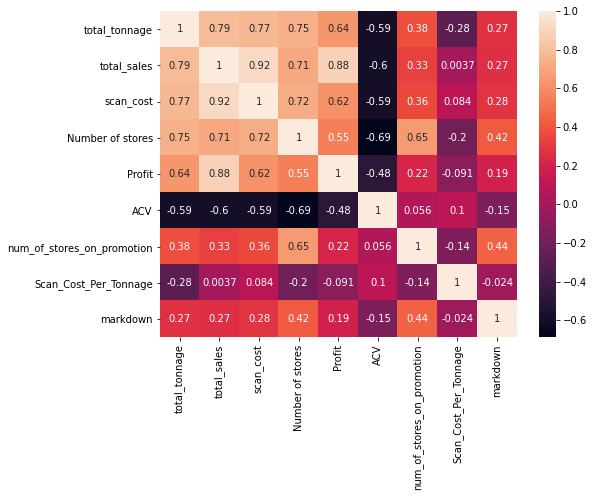

In [0]:
#strong correlation cut-off
a=0.25


strong_corrs=sorted_corrs[sorted_corrs>a]
corrmatrix=df_filter[strong_corrs.index].corr()
fig,ax=plt.subplots(figsize=(8,6))
sns.heatmap(corrmatrix,ax=ax,annot=True)

In [0]:
df_filter_more = df_filter[strong_corrs.index].drop(["Number of stores","scan_cost","Profit"],axis=1)

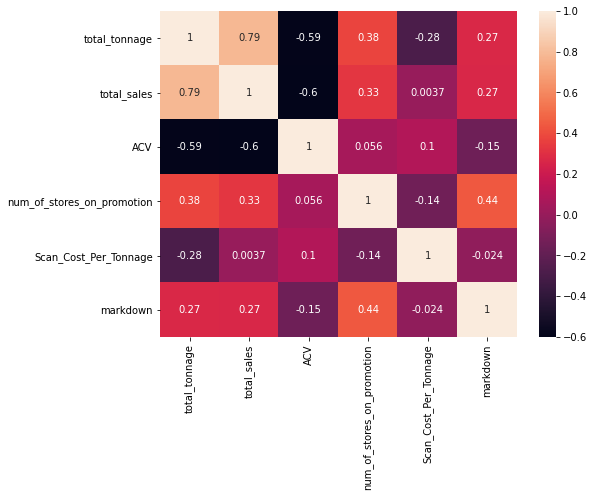

In [0]:
fig,ax=plt.subplots(figsize=(8,6))
sns.heatmap(df_filter_more.corr(),ax=ax,annot=True)

In [0]:
df_filter_more.corr()["total_tonnage"].abs().sort_values()

markdown                      0.273750
Scan_Cost_Per_Tonnage         0.282747
num_of_stores_on_promotion    0.376529
ACV                           0.594288
total_sales                   0.786582
total_tonnage                 1.000000
Name: total_tonnage, dtype: float64

### P-value analysis

In [0]:
from scipy import stats
from sklearn.preprocessing import StandardScaler
import statsmodels.api as sm

In [0]:
for col in df_filter.columns:
  print("Pearson correlation of {}:".format(col))
  Pearson_coef,p_value = stats.pearsonr(df_filter[col],df_filter['total_tonnage'])
  print("Coefficient :{} P-value :{}".format(Pearson_coef,p_value))
  print("\n")

Pearson correlation of Number of stores:
Coefficient :0.7488127118157113 P-value :0.0


Pearson correlation of markdown:
Coefficient :0.27374998864997246 P-value :0.0


Pearson correlation of scan_cost:
Coefficient :0.7701718813209166 P-value :0.0


Pearson correlation of promos:
Coefficient :0.18211810702283474 P-value :0.0


Pearson correlation of print_ad:
Coefficient :0.12145950635360508 P-value :1.2914168790971137e-259


Pearson correlation of digital_ad:
Coefficient :0.05523370339762711 P-value :6.6087907420025e-55


Pearson correlation of instore_ad:
Coefficient :0.12986335175024127 P-value :8.636799300411546e-297


Pearson correlation of mechanism of promotion:
Coefficient :0.12951740105316764 P-value :3.2907144110431506e-295


Pearson correlation of national_brand:
Coefficient :-0.2248489854917886 P-value :0.0


Pearson correlation of total_tonnage:
Coefficient :0.9999999999999943 P-value :0.0


Pearson correlation of total_sales:
Coefficient :0.7865821896553369 P-value :0.0



### Model

In [0]:

df_cat = dfc.groupby("Category")

In [53]:
df_cat.first()

,Group Id,AD_WEEK_ENDING_DATE,Number of stores,markdown,scan_cost,promos,print_ad,digital_ad,instore_ad,mechanism of promotion,national_brand,total_tonnage,total_sales,price,num_of_stores_on_promotion,Month,DayofWeek,Year,Number of Week,ACV,Markdown_Per_Tonnage,Scan_Cost_Per_Tonnage,Profit,Profit_Per_Tonnage,Profit_Margin,List_price
Category,,,,,,,,,,,,,,,,,,,,,,,,,,
575,30601,2017-10-01,100,49.34,7290.068,1,1,0,1,4,1,1804.00,9935.3000,1.492235,71,10,6,2017,39,0.710000,0.027350,4.041058,2645.2320,1.466315,0.362854,0.000015
786,7273026310,2018-04-24,99,49.34,1053.000,1,0,0,1,4,1,1080.00,1596.5000,1.478241,45,4,1,2018,17,0.454545,0.045685,0.975000,543.5000,0.503241,0.516144,0.000042
790,85392300293,2017-01-17,73,84.16,785.700,1,1,0,1,5,1,582.00,1155.0000,1.984536,73,1,1,2017,3,1.000000,0.144605,1.350000,369.3000,0.634536,0.470027,0.000248
1010,93356,2019-07-30,115,6.64,3081.954,1,0,0,1,3,1,1804.00,5129.0575,4.279107,12,7,1,2019,31,0.104348,0.003681,1.708400,2047.1035,1.134758,0.664223,0.000002
1102,20378100000,2017-06-27,14,0.00,4821.138,0,0,0,0,0,0,2088.88,7213.3100,3.453195,11,6,1,2017,26,0.785714,0.000000,2.308001,2392.1720,1.145194,0.496184,0.000000
1322,32032,2018-04-17,101,49.34,3081.954,1,1,0,1,3,1,1804.00,5129.0575,2.336570,31,4,1,2018,16,0.306931,0.027350,1.708400,2047.1035,1.134758,0.664223,0.000015


In [0]:
def predict_category(category):  
  df_ctg = df_cat.get_group(category)
  df_train = df_ctg.groupby(['Group Id','print_ad', 'digital_ad','instore_ad', 'mechanism of promotion','Number of Week','Year'],as_index=False).agg({'price':"mean",
                                                                                                                              'ACV':"mean",
                                                                                                                              'Markdown_Per_Tonnage':"mean",
                                                                                                                              'Scan_Cost_Per_Tonnage':"mean",
                                                                                                                              "total_sales":"mean",
                                                                                                                              'total_tonnage':"mean"})
  
  X = df_train.drop(["total_tonnage","total_sales","Year","Group Id"],axis=1).values
  Y = df_train["total_tonnage"].values
  sc = StandardScaler()
  x = sc.fit_transform(X)
  y = sc.fit_transform(Y.reshape(-1,1))
 

  x_train,x_test,y_train,y_test = train_test_split(x,y)
  reg = LinearRegression().fit(x_train,y_train)
  y_pred = reg.predict(x_test)


  #Training Report
  print("Training Results ")
  x_inter = sm.add_constant(x_train)
  model = sm.OLS(y_train,x_inter)
  results = model.fit()
  print(results.summary())

  print("\n")

  #Testing report
  print("Testing Results")
  x_test_inter = sm.add_constant(x_test)
  predictions = results.predict(x_test_inter)

  print("R squared :{}".format(r2_score(y_test,predictions)))
  print("Mean Squared Error :{}".format(mean_squared_error(y_test, predictions)))
  print("Mean Absolute Error :{}".format(mean_absolute_error(y_test,predictions)))

  print("\n")
  print("Model Evaluation")
  # Mean Squared Error
  print("Mean Squared Error :{}".format(mean_squared_error(y_test, y_pred)))
  
  # R Squared
  r2 = r2_score(y_test,y_pred)
  print("R squared :{}".format(r2))

  #Adjusted R squared
  n,p = X.shape
  adj_r2 = 1 - (1-r2)*(n-1)/(n-p-1)
  print("Adjusted R square :{}".format(adj_r2))

  # Mean Absolute Error
  print("Mean Absolute Error :{}".format(mean_absolute_error(y_test,y_pred)))

  # RMSE
  print("RMSE :{}".format(np.sqrt(mean_absolute_error(y_test,y_pred))))
  
  #y_test = sc.inverse_transform(y_test)
  #y_pred = sc.inverse_transform(y_pred)
  #return y_test,y_pred
  return reg,df_train

### Function to plot the predictions

In [0]:
def plot_pred(y_test,y_pred,weeks,year,category):
  y_test = y_test.reshape(len(y_test))
  y_pred = y_pred.reshape(len(y_pred))
  plots = pd.DataFrame({"Year":year[0:],
                        "Weeks":weeks[0:],
                          "Actual":y_test[0:],
                          "Predictions":y_pred[0:]})
  plots = plots.groupby(["Year","Weeks"],as_index=False).agg({"Actual":"mean","Predictions":"mean"})
  # plot
  plt.figure(figsize=(14,4))
  plt.plot(plots["Actual"]/plots["Actual"].max(), label="Actual")
  plt.plot(plots["Predictions"]/plots["Predictions"].max() , color='red',label="Predictions")
  plt.ylabel("Tonnage")
  plt.xlabel("Week")
  plt.legend(loc="lower left")
  plt.title("Tonnage Prediction(Category = {})".format(category))
  plt.show()

### Function to export the result

In [0]:
def export_results(y_test,y_pred,index_val,reg):
  y_test = y_test.reshape(len(y_test))
  y_pred = y_pred.reshape(len(y_pred))
  results = pd.DataFrame({"Actual":y_test[0:],
                          "Predictions":y_pred[0:]})
  results = results.set_index(index_val,drop=True)
  results = results.groupby(results.index).agg({"Actual":"mean",
                                                "Predictions":"mean"})
  results["Abs_error_%"]= abs((results["Predictions"] - results["Actual"])/results["Actual"])*100
  results.to_excel("results.xlsx")
  print("Exported!!")
  print("Created results.xlsx")

  reg_index = ['print_ad', 'digital_ad','instore_ad', 'mechanism of promotion','price','Number of Week',
                     'ACV','Markdown_Per_Tonnage', 'Scan_Cost_Per_Tonnage']
  Coeff = reg.coef_
  Inter = reg.intercept_
  output = pd.DataFrame({"Variables":reg_index[0:],"Coefficients":Coeff[0][0:],"Intercept":Inter[0]})
  output.set_index("Variables",inplace=True)
  output.to_excel("RegressionCoeff.xlsx")
  print("Created RegressionCoeff.xlsx")

### Run this cell to enter category

Enter category [ 790,  575,  786, 1322, 1010, 1102]: 1102



Training Results 
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.559
Model:                            OLS   Adj. R-squared:                  0.557
Method:                 Least Squares   F-statistic:                     501.0
Date:                Sat, 16 May 2020   Prob (F-statistic):               0.00
Time:                        16:28:50   Log-Likelihood:                -3647.4
No. Observations:                3574   AIC:                             7315.
Df Residuals:                    3564   BIC:                             7377.
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------

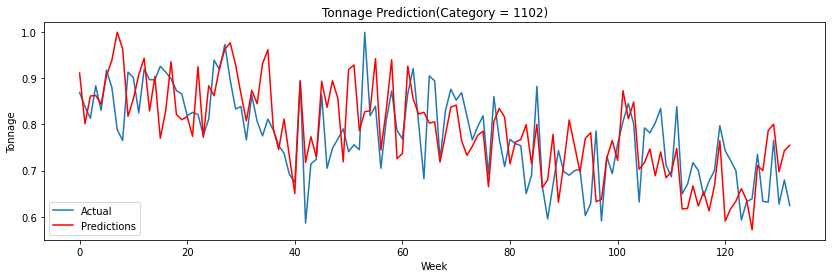

Exported!!
Created results.xlsx
[[-0.01480831 -0.01481358  0.01487946 -0.01339884 -0.03032493 -0.02387749
  -0.48198611 -0.02042177 -0.3996737 ]]
[0.00910088]
Created RegressionCoeff.xlsx


The Combination for which Profit of 9389.226 is achievied




Group Id                           2718255675
AD_WEEK_ENDING_DATE       2019-05-11 00:00:00
promos                                      0
print_ad                                    0
digital_ad                                  0
instore_ad                                  0
mechanism of promotion                      0
Name: 9510, dtype: object

In [66]:
category = int(input("Enter category [ 790,  575,  786, 1322, 1010, 1102]: "))
print("\n\n")
#y_test, y_pred = predict_category(category)  #linear regression model

#plot_pred(y_test,y_pred,category)  #plot
#export_results(y_test,y_pred) #export to excel


model, df_sample = predict_category(category)  #linear regression model

scr = StandardScaler()
input_d = df_sample.drop(["total_tonnage","total_sales","Year","Group Id"],axis=1)
input_d = scr.fit_transform(input_d)
index_val = df_sample["Group Id"]
weeks = df_sample["Number of Week"].to_list()
year = df_sample["Year"].to_list()
dtr = df_sample["total_sales"].sum()
sales = df_sample["total_sales"].to_list()
actual = df_sample["total_tonnage"].values
actual = scr.fit_transform(actual.reshape(-1,1))
pred = model.predict(input_d)

actual = scr.inverse_transform(actual)
pred = scr.inverse_transform(pred)

for i in range(len(pred)):
  if pred[i] < 0:
    pred[i] = 0

term = (abs((actual)-pred)/abs(actual))*100*sales[0:]
wmape =  term.sum()/dtr
print("MAPE(Weighted) :{}".format(wmape))


term_ln = (abs((actual)-pred)/abs(actual))*100*np.log(sales[0:])
wmape_ln =  term_ln.sum()/dtr
print("MAPE_Log(Weighted) :{}".format(wmape_ln))



plot_pred(actual,pred,weeks,year,category)
export_results(actual,pred,index_val,model)
print("\n")
df_profit = df_cat.get_group(category)
Max_profit = df_profit.sort_values(by=["Profit"],ascending=False)
print("The Combination for which Profit of {} is achievied".format(Max_profit["Profit"].iloc[0]))
print("\n")
Max_profit[["Group Id","AD_WEEK_ENDING_DATE","promos","print_ad","digital_ad","instore_ad","mechanism of promotion"]].iloc[0]